In [1]:
def swap_clusters(nc,  rep_a, rep_b, var_to_replace="cluster",):
    # Extract the variable as a DataArray
    arr = nc[var_to_replace]

    # Step 1: Temporarily mark 0 as 100
    arr = xr.where(np.isfinite(arr) & (arr == rep_a), -1, arr)

    # Step 2: Replace 3 with 0
    arr = xr.where(np.isfinite(arr) & (arr == rep_b), rep_a, arr)

    # Step 3: Replace temporary 100 (originally 0) with -1
    arr = xr.where(np.isfinite(arr) & (arr == -1), rep_b, arr)

    # Return a new dataset with the updated variable
    return nc.assign({var_to_replace: arr})


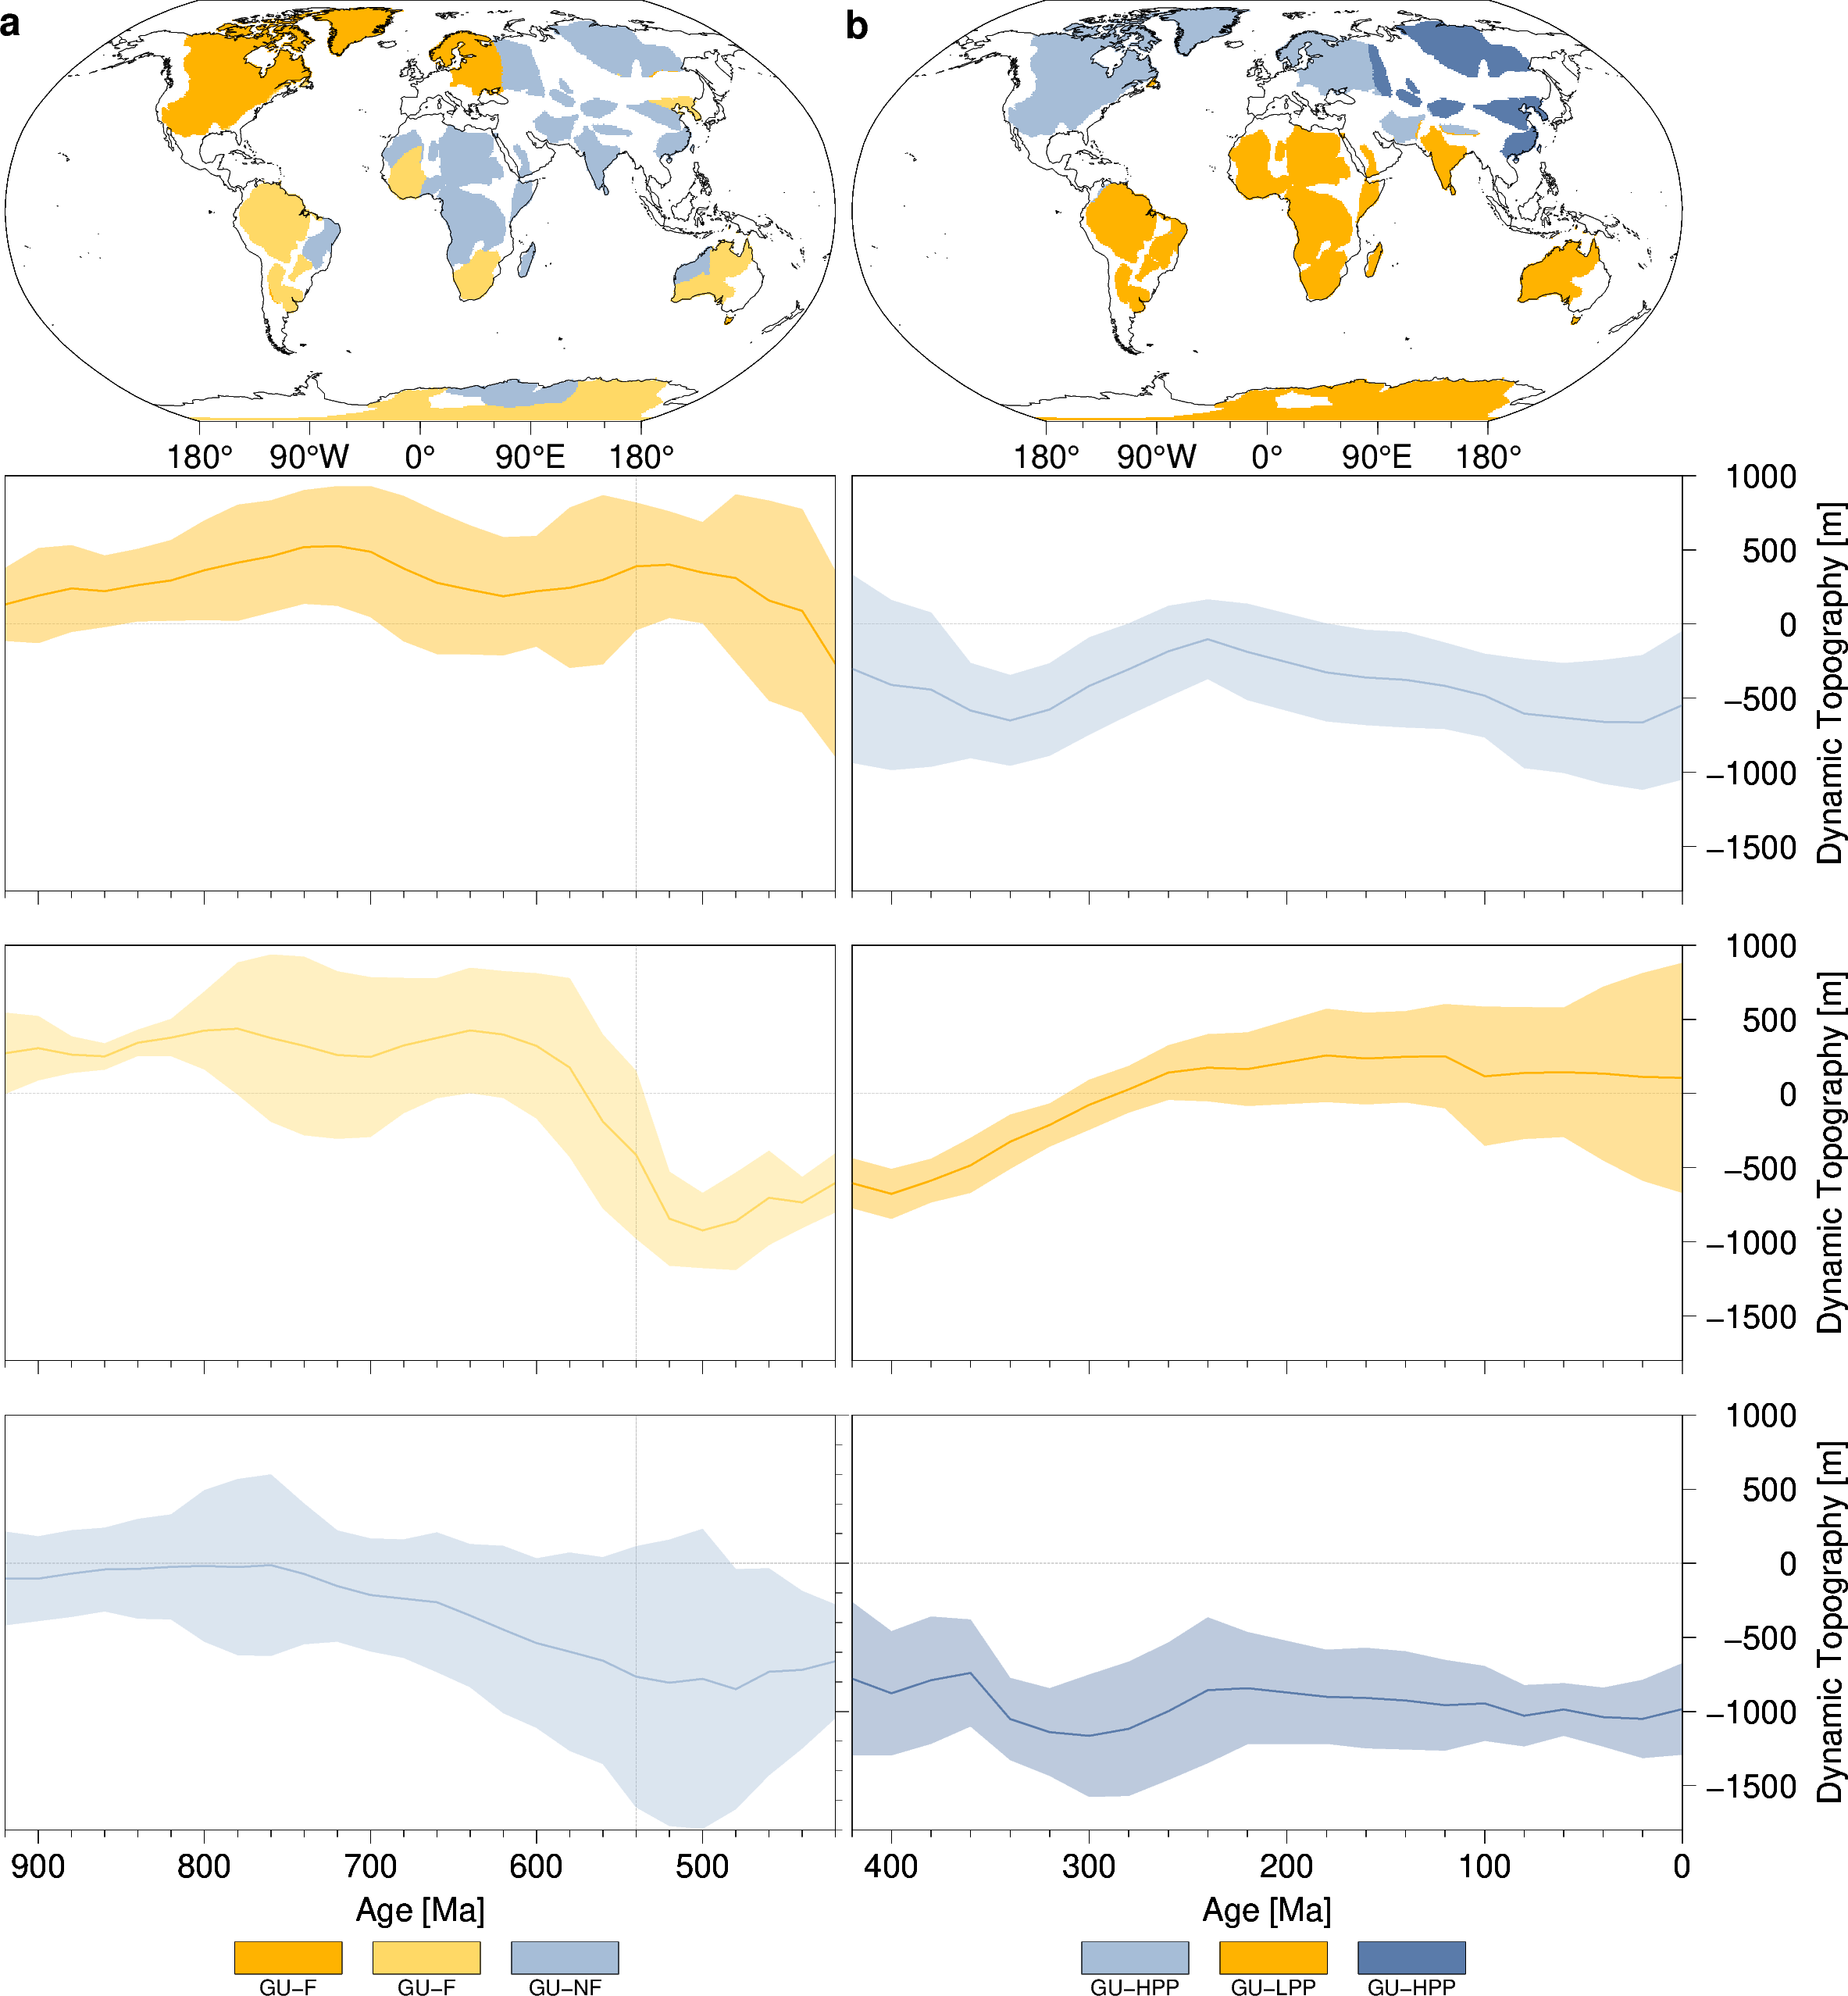

In [2]:
#pygmt all in one for spatio-temporal cluster analysis and elbow plot
import pygmt
import xarray as xr
import glob
import pandas as pd
import numpy as np
import warnings
import rioxarray as rxr
import geopandas as gpd
warnings.filterwarnings("ignore")

models = ['gld434'] #['gld428', 'gld504','gld560','gld563', 'gld564', 'gld565', ]
model ='gld434'
clusters_ =3

def model_mapping(time_window):
    clusters_ =3
    if time_window =='420-920':
        

        series =[0, clusters_ -1, 1]
        color_model= "+cGU-F,GU-F,GU-NF"
        cmap='#FFB300,#FFD966,#A6BDD7'
        mapping ={
            'gld421' : {0:1, 1:2},
            'gld428' : {0:1, 1:2},
            'gld431' : {0:2, 1:2},
            'gld434' : {0:1, 1:2},
            'gld486' : {0:1, 1:2,},
            'gld504' : {0:1, 1:2,},
            
        }
    else:
        series =[0, clusters_ -1, 1]
        color_model= "+cGU-HPP,GU-LPP,GU-HPP"
        cmap='#A6BDD7,#FFB300,#5A7BAA'
        mapping ={
            'gld421' : {0:1, 1:2},
            'gld428' : {0:1, 1:2},
            'gld431' : {0:1, 1:2},
            'gld434' : {0:2, 1:2 },
            'gld486' : {0:1, 1:2,},
            'gld504' : {0:1, 1:2,},
        }
            
    return series, color_model, cmap, mapping
        
time_windows =['420-920', '0-420']

#figure
fig = pygmt.Figure()

#figure panels
fig_width ="18c"
fig_height = "20c"
subplot_depth ="5c"
text_labels = [ 'M4', 'M4' ] #['a)','b)','c)','d)','e)','f)']
fig_labels =['a','b']
clearance=None

pygmt.config(GMT_VERBOSE='q')
with fig.subplot(
    nrows=4,
    ncols=2,
    figsize=(fig_width, fig_height),
    sharey=True, 
    #sharex='b',
    frame='lrbt',
    #autolabel='a'
):
    for j,  window in enumerate( time_windows):
    
        for k in range(4):
            if k==0:
                
                cluster_fpath = f'ClusterAnalysis/cluster_{model}_{window}_{clusters_}.nc'
                NA_nc_fpath = f'ClusterAnalysis/NA_{model}_{window}.nc'
                
                cluster = xr.open_dataset(cluster_fpath)
                #print(cluster.z.min().values, cluster.z.max().values)

                #-------------------------masking with land boundary------------------------#
                
                land_mask_file = glob.glob('./orogens/ne*/*shp')
                land_mask = gpd.read_file(land_mask_file[0])
                
                cluster_projected=cluster.rio.write_crs("epsg:4326", inplace=True).rename({'lon':'x', 'lat':'y'})
                cluster=cluster_projected.rio.clip(geometries=land_mask.geometry, crs=4326, all_touched=True).drop('spatial_ref').rename({'x':'lon', 'y':'lat'})
        
                if model in models:
                    series, color_model, cmap, mapping = model_mapping(window)
                    mapping_model =mapping[model]
                    for rep_a, rep_b in mapping_model.items():
                        cluster = swap_clusters(cluster, rep_a, rep_b)
        
              
                clearance =['s0c']
                offset="0c/0.1c",
                
                projection ="N9c"
        
                with fig.set_panel(panel=[0,j],clearance=clearance):
                    pygmt.config(MAP_FRAME_TYPE="plain", MAP_FRAME_PEN="0.01", FONT_TITLE="10p", FONT_HEADING ='10p', FONT_LABEL="10p", FONT_ANNOT="10p", FONT_ANNOT_PRIMARY="10p",MAP_TITLE_OFFSET ="-0.3c",MAP_TICK_PEN='0.01')
                    # plot cluster in frame c
                    pygmt.makecpt(cmap=cmap, series=series, color_model= color_model)
                    
                    fig.grdimage(grid=cluster.cluster, projection=projection, region= 'd', nan_transparent="+znan",  cmap=True , frame=['lrSt'])
                    fig.coast(shorelines="1/0.1p", region='d', projection=projection)
                    

                fig.text(
                    position ="TL",
                    text=fig_labels[j],
                    font="12p,Helvetica-Bold,black",    # font size, style, colo                  
                    justify="CM", # center-middle alignment
                    no_clip=True,
                    offset ='0.05/-0.3'
                )
                
                fig.basemap(region='d', projection=projection, frame= ['lrSt'])
            
     
            else:
            
                cluster_fpath = f'ClusterAnalysis/cluster_{model}_{window}_{clusters_}.nc'
                NA_nc_fpath = f'ClusterAnalysis/NA_{model}_{window}.nc'
                
                cluster = xr.open_dataset(cluster_fpath)
                #print(cluster.age.values)
                
                #print(cluster.z.min().values, cluster.z.max().values)
                NA_Nc = xr.open_dataset(NA_nc_fpath)
    
                #-------------------------masking with land boundary------------------------#
                
                land_mask_file = glob.glob('./orogens/ne*/*shp')
                land_mask = gpd.read_file(land_mask_file[0])
                cluster_projected=cluster.rio.write_crs("epsg:4326", inplace=True).rename({'lon':'x', 'lat':'y'})
                cluster=cluster_projected.rio.clip(geometries=land_mask.geometry, crs=4326, all_touched=True).drop('spatial_ref').rename({'x':'lon', 'y':'lat'})
        
                if model in models:
                    series, color_model, cmap, mapping = model_mapping(window)
                    mapping_model =mapping[model]
                    for rep_a, rep_b in mapping_model.items():
                        cluster = swap_clusters(cluster, rep_a, rep_b)
                
            
                    df = cluster.to_dataframe().dropna().reset_index().drop(['lat','lon'], axis=1)
                    agg = (
                        df.groupby(["cluster", 'age'])
                          .agg(["mean", "std", 'min', 'max'])                        # compute mean & std
                          .reset_index()                               # turn location back into a column
                    ).droplevel(1, axis=1)
                    agg.columns =['cluster', 'age', 'z', 'std', 'min', 'max']
                    #agg['std'] = agg['std'].apply(lambda x: x*2)
                    
                   
                    
                    #print('agg:',agg.head(), agg.shape)
                    df = df.groupby(['cluster','age']).mean('cluster').reset_index()
                    #print('mean:', df.head(), df.shape)
                    df_NA = NA_Nc.mean(dim =['lat','lon']).to_dataframe().reset_index()
                    #print(df_NA.head())
                    df_NA_agg =NA_Nc.to_dataframe().dropna().reset_index().drop(['lat','lon'],axis=1)
                    
                    df_NA_agg =(
                        df_NA_agg.groupby(['age'])
                          .agg(["mean", "std"])                        # compute mean & std
                          .reset_index()                               # turn location back into a column
                    ).droplevel(1, axis=1)
                    df_NA_agg.columns =['age', 'z', 'std']
        
                    df_NA_agg['upper_std'] = df_NA_agg['z'] + 2*df_NA_agg['std']
                    df_NA_agg['lower_std'] = df_NA_agg['z'] - 2*df_NA_agg['std']
        
        
                    # split time window to obtain start and end age for region
                    start, end = window.split('-')
                    region_cl = [int(start),int(end), -1800, 1000] #agg['min'].min()*1.2, agg['max'].max()*1.1,]
                    #print(df_NA_agg.head())
                    proj_cl ="X-9c/4.5c"
        
                    if j>0 and k<3:
                        frame =['lstE', 'ya500+lDynamic Topography [m]']
                    elif j==0 and k==3:
                        
                        frame=['lSte', 'x+lAge [Ma]']
                    elif j>0 and k==3:
                        frame= ['lStE','x+lAge [Ma]','ya500+lDynamic Topography [m]',]
                    else:
                        frame=['lstr']
                    
                
                
                    with fig.set_panel(panel=[k,j],clearance=clearance):
                        pygmt.config(MAP_FRAME_TYPE="plain", MAP_FRAME_PEN="0.01", FONT_TITLE="10p, Helvetica", FONT_HEADING ='10p, Helvetica', FONT_LABEL="10p, Helvetica", FONT_ANNOT="10p, Helvetica", FONT_ANNOT_PRIMARY="10p, Helvetica",MAP_TITLE_OFFSET ="-0.3c",MAP_TICK_PEN='0.01')
    
                        #prepare dataset
                        df_selected = df[df.cluster==k-1]
                        agg_selected = agg[agg.cluster==k-1]
                        agg_selected['upper_std'] = agg_selected['z'] + 2*agg_selected['std']
                        agg_selected['lower_std'] = agg_selected['z'] - 2*agg_selected['std']
                        xs = pd.concat([agg_selected["age"], agg_selected["age"][::-1]]).to_numpy()
                        ys = pd.concat([agg_selected["min"], agg_selected["max"][::-1]]).to_numpy()
                        ys_na = pd.concat([df_NA_agg["lower_std"], df_NA_agg["upper_std"][::-1]]).to_numpy()
                        ys_std = pd.concat([agg_selected["lower_std"], agg_selected["upper_std"][::-1]]).to_numpy()
    
                        #Plotting
                        pygmt.makecpt(cmap=cmap, series=series, color_model= color_model)
                        fig.basemap(region=region_cl, projection=proj_cl, frame= frame)  
                        fig.plot(x=[540]*len(df_NA.z), y=np.linspace(agg_selected['min'].min()*3, agg_selected['max'].max()*3, len(df_NA.z)), region=region_cl, projection = proj_cl, pen='0.1p,grey, --')
                        fig.plot(x=df_NA.age, y=[0]*df_NA.z, region=region_cl, projection = proj_cl, pen='0.1p,grey, --')
                        fig.plot(x=xs, y=ys_std, region=region_cl, projection = proj_cl,zvalue=k-1, fill='+z', cmap=True, frame=['lbrt'], transparency=60 )
                        fig.plot(x=df_selected.age, y=df_selected.z, region=region_cl, projection = proj_cl,zvalue=k-1, pen='0.5p,+z', cmap=True, frame=frame, )
                        #fig.plot(x=agg_selected.age, y=agg_selected.upper_std, region=region_cl, projection = proj_cl,zvalue=i, fill='+z', cmap=True, frame=['lbrt'], transparency=60 )
                        #fig.plot(x=xs, y=ys, region=region_cl, projection = proj_cl,zvalue=i, fill='+z', cmap=True, frame=['lbrt'], transparency=60 )
                        
                        
                        
        with pygmt.config(FONT_ANNOT_PRIMARY='12p'):
            fig.colorbar(cmap=True, position="JMR+o-6.5c/-3.75c+w4.5c/0.35c+h")
fig.savefig(f'./ExtendedDataFigures/EDF4_Cluster_and_DT_evolution_with_errorbar-2SD.png', dpi=600, )
        
fig.show()